#Odisha RAINFALL TREND ANALYSIS

Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### INSTALLING NECESSARY LIBRARIES

In [ ]:
!pip install geopandas

In [ ]:
!pip install tslearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 369.8/369.8 kB 5.4 MB/s eta 0:00:00


In [ ]:
!pip install fastdtw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512579 sha256=9fcb9d6a71e8b3d25de7187f85c165f3e9ea82d946c0710390227a943679e2b4
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d513c736bb93910277e1528ef4
Successfully built fastdtw


In [ ]:

!pip install pymannkendall

In [ ]:
!pip install pyhomogeneity

In [ ]:
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

import pyproj
from shapely.geometry import Point

import pandas as pd

from fastdtw import fastdtw

from scipy.stats import kendalltau, norm, linregress

import pyhomogeneity as hg

In [ ]:
from scipy.stats import zscore

### IMPLEMENTATION

IMPORTING INDIAN METEROLOGICAL DEPARTMENT (IMD) RAINFALL DATASETS 2022 TO 1901

In [ ]:
data_path = '/content/drive/My Drive/Rainfall-dataset-2022to1901/'


In [ ]:

rainfall_data_2001 = xr.open_dataset(data_path + '2001.nc')
print(rainfall_data_2001.head())

<xarray.Dataset>
Dimensions:    (LONGITUDE: 5, LATITUDE: 5, TIME: 5)
Coordinates:
  * LONGITUDE  (LONGITUDE) float64 66.5 67.5 68.5 69.5 70.5
  * LATITUDE   (LATITUDE) float64 6.5 7.5 8.5 9.5 10.5
  * TIME       (TIME) datetime64[ns] 2001-01-01 2001-01-02 ... 2001-01-05
Data variables:
    RAINFALL   (TIME, LATITUDE, LONGITUDE) float64 ...
Attributes:
    history:      FERRET V7.5 (optimized) 28-Mar-22
    Conventions:  CF-1.6


PRINTING THE LATITUDNAL AND LONGITUDNAL RANGE OF THE RAINFALL DATASETS

In [ ]:
# Access the longitude and latitude coordinates from the dataset
longitude_values = rainfall_data_2001['LONGITUDE'].values
latitude_values = rainfall_data_2001['LATITUDE'].values

# Find the minimum and maximum values for longitude and latitude
min_longitude = longitude_values.min()
max_longitude = longitude_values.max()
min_latitude = latitude_values.min()
max_latitude = latitude_values.max()

# Print the range of longitude and latitude
print(f"Longitude Range: ({min_longitude}, {max_longitude})")
print(f"Latitude Range: ({min_latitude}, {max_latitude})")

Longitude Range: (66.5, 100.5)
Latitude Range: (6.5, 38.5)


In [ ]:
print(f"Latitude values: {latitude_values}", "\n")

print(f"Longitude values: {longitude_values}")

Latitude values: [ 6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5 14.5 15.5 16.5 17.5 18.5 19.5
 20.5 21.5 22.5 23.5 24.5 25.5 26.5 27.5 28.5 29.5 30.5 31.5 32.5 33.5
 34.5 35.5 36.5 37.5 38.5] 

Longitude values: [ 66.5  67.5  68.5  69.5  70.5  71.5  72.5  73.5  74.5  75.5  76.5  77.5
  78.5  79.5  80.5  81.5  82.5  83.5  84.5  85.5  86.5  87.5  88.5  89.5
  90.5  91.5  92.5  93.5  94.5  95.5  96.5  97.5  98.5  99.5 100.5]


IMPORTING THE SHAPEFILE OF INDIA

In [ ]:
India_shapefile_path = '/content/drive/My Drive/AmmuProject/IndiaDisShapefile/output.shp'
India_shapefile = gpd.read_file(India_shapefile_path)
print(India_shapefile)

     objectid statecode    statename state_ut distcode      distname  \
0           1        05  Uttarakhand    STATE      066      Nainital   
1           2        05  Uttarakhand    STATE      060      Dehradun   
2           3        05  Uttarakhand    STATE      064        Almora   
3           4        05  Uttarakhand    STATE      065     Champawat   
4           5        05  Uttarakhand    STATE      056    Uttarkashi   
..        ...       ...          ...      ...      ...           ...   
688       691        36    Telangana    STATE      T28    Wanaparthy   
689       692        36    Telangana    STATE      T27     Vikarabad   
690       693        36    Telangana    STATE      T13  Mahabubnagar   
691        41        01       Ladakh    STATE      004        Kargil   
692        34        01       Ladakh    STATE      003  Leh (Ladakh)   

     distarea  totalpopul   totalhh  totpopmale  totpopfema    st_areasha  \
0      4251.0    954605.0  191383.0    493666.0    460939.

In [ ]:
print(India_shapefile['statename'].unique())

['Uttarakhand' 'Himachal Pradesh' 'Madhya Pradesh' 'Jammu & Kashmir'
 'Gujarat' 'Andhra Pradesh' 'West Bengal' 'Uttar Pradesh' 'Daman & Diu'
 'Kerala' 'Lakshadweep' 'Sikkim' 'Bihar' 'Dadra & Nagar Haveli'
 'Jharkhand' 'NCT of Delhi' 'Haryana' 'Punjab' 'Karnataka' 'Maharashtra'
 'Chandigarh' 'Pondicherry' 'Manipur' 'Mizoram' 'Tamil Nadu' 'Nagaland'
 'Arunachal Pradesh' 'Assam' 'Tripura' 'Meghalaya' 'Telangana' 'Goa'
 'Andaman & Nicobar Islands' 'Orissa' 'Rajasthan' 'Chhatisgarh' 'Ladakh']






FILTERING Odisha'S GEODATAFRAME FROM THE SHAPEFILE OF INDIA

In [ ]:
# Filter the GeoDataFrame to get the Orissa polygon
Odisha_shapefile = India_shapefile[India_shapefile['statename'] == 'Orissa']
print(Odisha_shapefile)

     objectid statecode statename state_ut distcode        distname  distarea  \
454       466        21    Orissa    STATE      384          Anugul    6375.0   
475       468        21    Orissa    STATE      398         Koraput    8807.0   
477       471        21    Orissa    STATE      397    Nabarangapur    5291.0   
478       472        21    Orissa    STATE      370         Bargarh    5837.0   
485       494        21    Orissa    STATE      393        Balangir    6575.0   
530       464        21    Orissa    STATE      392      Subarnapur    2337.0   
531       465        21    Orissa    STATE      387            Puri    3479.0   
532       467        21    Orissa    STATE      373        Debagarh    2940.0   
535       473        21    Orissa    STATE      380  Jagatsinghapur    1668.0   
536       474        21    Orissa    STATE      390       Kandhamal    8021.0   
537       475        21    Orissa    STATE      386         Khordha    2813.0   
538       476        21    O

PRINTING THE LATITUDNAL AND LONGITUDNAL RANGE OF Odisha

In [ ]:
# Extract the geometry of the Odisha polygon
Odisha_geometry = Odisha_shapefile['geometry'].iloc[0]

# Get the bounding box (envelope) of the Odisha polygon
Odisha_bbox = Odisha_geometry.bounds

# Extract latitude and longitude range
min_longitude, min_latitude, max_longitude, max_latitude = Odisha_bbox

print(f"Latitude Range: {min_latitude} to {max_latitude}")
print(f"Longitude Range: {min_longitude} to {max_longitude}")


Latitude Range: 20.528810000355314 to 21.677620000380703
Longitude Range: 84.26635999997598 to 85.40834000001095


In [ ]:
#min_longitude, min_latitude, max_longitude, max_latitude = 91.20,26.28,97.30,29.30

print(f"Latitude Range: {min_latitude} to {max_latitude}")
print(f"Longitude Range: {min_longitude} to {max_longitude}")

Latitude Range: 20.528810000355314 to 21.677620000380703
Longitude Range: 84.26635999997598 to 85.40834000001095


AVERAGE DAILY RAINFALL OF Odisha FROM 2022 TO 1901

In [ ]:
import pyproj
from shapely.geometry import Point

for year in range(2022, 1900, -1):
  rainfall_data = xr.open_dataset(data_path + f'{year}.nc')
  # Find latitude and longitude indices within the Odisha's boundaries
  latitude_indices = np.where((rainfall_data['LATITUDE'] >= min_latitude) & (rainfall_data['LATITUDE'] <= max_latitude))[0]
  longitude_indices = np.where((rainfall_data['LONGITUDE'] >= min_longitude) & (rainfall_data['LONGITUDE'] <= max_longitude))[0]

  # Slice the rainfall data for Odisha
  Odisha_rainfall_data = rainfall_data['RAINFALL'][:, latitude_indices, longitude_indices]
  #Calculate the average and sum rainfall for each day over the entire time range
  average_rainfall_per_day = np.mean(Odisha_rainfall_data, axis=(1, 2))
  sum_rainfall_per_day = np.sum(Odisha_rainfall_data, axis=(1, 2))
  # Plot the average rainfall for each day using a line plot
  plt.figure(figsize=(12, 6))
  plt.plot(np.arange(1, len(average_rainfall_per_day) + 1),average_rainfall_per_day , marker='o', linestyle='-', color='b')
  plt.xlabel('Day of the Year')
  plt.ylabel('Average Rainfall (mm)')
  plt.title(f'Average Daily Rainfall in Odisha for {year}')
  plt.grid(True)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Load the NetCDF file
file_pattern = '{year}.nc'  # Adjust the pattern to match your file names

# Load all NetCDF files
years = np.arange(1901, 2023)  # Assuming your data covers the years from 1910 to 2022
ds_list = [xr.open_dataset(data_path + file_pattern.format(year=year)) for year in years]
# latitude and longitude ranges for Odisha


# Filter the NetCDF files to include only those within the defined latitude and longitude ranges
ds_list = [ds for ds in ds_list if (ds['LATITUDE'].min() >= min_latitude and ds['LATITUDE'].max() <= max_latitude) and (ds['LONGITUDE'].min() >= min_longitude and ds['LONGITUDE'].max() <= max_longitude)]


# Calculate annual average rainfall for each year
for year in years:
    ds = xr.open_dataset(data_path + file_pattern.format(year=year))
    annual_avg_rainfall = ds['RAINFALL'].mean(dim=['LATITUDE', 'LONGITUDE'])

    # Plot the average rainfall for the current year
    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(1, len(annual_avg_rainfall.data) + 1), annual_avg_rainfall.data, marker='o', linestyle='-')
    plt.xlabel('Days')
    plt.ylabel('Average Rainfall (mm)')
    plt.title(f'Average Rainfall in {year}')
    plt.grid(True)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

SUM DAILY RAINFALL OF Odisha FROM 2022 TO 1901

In [ ]:
import pyproj
from shapely.geometry import Point

for year in range(2022, 1900, -1):
  rainfall_data = xr.open_dataset(data_path + f'{year}.nc')
  # Find latitude and longitude indices within the Odisha's boundaries
  latitude_indices = np.where((rainfall_data['LATITUDE'] >= min_latitude) & (rainfall_data['LATITUDE'] <= max_latitude))[0]
  longitude_indices = np.where((rainfall_data['LONGITUDE'] >= min_longitude) & (rainfall_data['LONGITUDE'] <= max_longitude))[0]

  # Slice the rainfall data for Odisha
  Odisha_rainfall_data = rainfall_data['RAINFALL'][:, latitude_indices, longitude_indices]
  #Calculate the average and sum rainfall for each day over the entire time range
  average_rainfall_per_day = np.mean(Odisha_rainfall_data, axis=(1, 2))
  sum_rainfall_per_day = np.sum(Odisha_rainfall_data, axis=(1, 2))
  # Plot the sum rainfall for each day using a line plot
  plt.figure(figsize=(12, 6))
  plt.plot(np.arange(1, len(sum_rainfall_per_day) + 1),sum_rainfall_per_day , marker='o', linestyle='-', color='b')
  plt.xlabel('Day of the Year')
  plt.ylabel('Sum Rainfall (mm)')
  plt.title(f'Sum Daily Rainfall in Odisha for {year}')
  plt.grid(True)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

 MONTHLY RAINFALL OF Odisha FROM 2022 TO 1901 (Using average daily rainfall)

In [ ]:
for year in range(2022, 1900, -1):
    # Load the rainfall data for the current year
    rainfall_data = xr.open_dataset(data_path + f'{year}.nc')

    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    # Find latitude and longitude indices within the Odisha's boundaries
    latitude_indices = np.where((rainfall_data['LATITUDE'] >= min_latitude) & (rainfall_data['LATITUDE'] <= max_latitude))[0]
    longitude_indices = np.where((rainfall_data['LONGITUDE'] >= min_longitude) & (rainfall_data['LONGITUDE'] <= max_longitude))[0]

    # Slice the rainfall data for Odisha
    Odisha_rainfall_data = rainfall_data['RAINFALL'][:, latitude_indices, longitude_indices]
    average_rainfall_per_day = np.mean(Odisha_rainfall_data, axis=(1, 2))
    # Resample the data to monthly rainfall
    Odisha_monthly_rainfall = average_rainfall_per_day.resample(TIME='1M').sum()

    y_data = Odisha_monthly_rainfall.values.squeeze()

    # Plot the monthly rainfall using a line plot
    plt.figure(figsize=(12, 6))
    plt.plot(months, y_data, marker='o', linestyle='-', color='b')
    plt.xlabel('Month')
    plt.ylabel('Rainfall (mm)')
    plt.title(f'Monthly Rainfall in Odisha for {year}')
    plt.grid(True)
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

AVERAGE MONTHLY RAINFALL OF Odisha FROM 2022 TO 1901 (Using average daily rainfall)

In [ ]:
for year in range(2022, 1900, -1):
    # Load the rainfall data for the current year
    rainfall_data = xr.open_dataset(data_path + f'{year}.nc')

    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    # Find latitude and longitude indices within the Odisha's boundaries
    latitude_indices = np.where((rainfall_data['LATITUDE'] >= min_latitude) & (rainfall_data['LATITUDE'] <= max_latitude))[0]
    longitude_indices = np.where((rainfall_data['LONGITUDE'] >= min_longitude) & (rainfall_data['LONGITUDE'] <= max_longitude))[0]

    # Slice the rainfall data for Odisha
    Odisha_rainfall_data = rainfall_data['RAINFALL'][:, latitude_indices, longitude_indices]
    average_rainfall_per_day = np.mean(Odisha_rainfall_data, axis=(1, 2))
    # Resample the data to monthly averages
    Odisha_monthly_average_rainfall = average_rainfall_per_day.resample(TIME='1M').mean()

    y_data = Odisha_monthly_average_rainfall.values.squeeze()

    # Plot the average monthly rainfall using a line plot
    plt.figure(figsize=(12, 6))
    plt.plot(months, y_data, marker='o', linestyle='-', color='b')
    plt.xlabel('Month')
    plt.ylabel('Average Rainfall (mm)')
    plt.title(f'Average Monthly Rainfall in Odisha for {year}')
    plt.grid(True)
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

FREQUENCY OF MONTHLY RAINFALL FOR YEARS FROM 1901 TO 2022

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import calendar



# Loop through each year in descending order (from 2022 to 1901)
for year in range(2022, 1900, -1):
    # Load the rainfall data for the current year
    rainfall_data = xr.open_dataset(data_path + f'{year}.nc')

    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    # Find latitude and longitude indices within the Odisha's boundaries
    latitude_indices = np.where((rainfall_data['LATITUDE'] >= min_latitude) & (rainfall_data['LATITUDE'] <= max_latitude))[0]
    longitude_indices = np.where((rainfall_data['LONGITUDE'] >= min_longitude) & (rainfall_data['LONGITUDE'] <= max_longitude))[0]

    # Slice the rainfall data for Odisha
    Odisha_rainfall_data = rainfall_data['RAINFALL'][:, latitude_indices, longitude_indices]
    average_rainfall_per_day = np.mean(Odisha_rainfall_data, axis=(1, 2))

    # Resample the data to monthly rainfall and count occurrences
    Odisha_monthly_rainfall = average_rainfall_per_day.resample(TIME='1M').count()

    # Extract monthly rainfall frequency values
    y_data = Odisha_monthly_rainfall.values.squeeze()

    # Plot histogram for the frequency of rainfall occurrences for each month with month names on x-axis
    plt.figure(figsize=(8, 6))
    plt.bar(months, y_data, color='blue')
    plt.xlabel('Month')
    plt.ylabel('Number of Rainfall Occurrences')
    plt.title(f'Rainfall Occurrence Frequency Distribution - {year}')
    plt.grid(True)
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

 DYNAMIC TIME WARPING (DTW) FOR ANALYSING THE SIMILARITY OF MONTHLY AVERAGE RAINFALL FROM 2022 TO 1901.
 ##### Lowest peaks : Highest similarity (vice versa)

In [ ]:
for year1 in range(2022,1900,-1):
  dfs = []
  # Load the rainfall data for the current years
  rainfall_data1 = xr.open_dataset(data_path + f'{year1}.nc')

  # Find latitude and longitude indices within the Odisha's boundaries
  latitude_indices1 = np.where((rainfall_data1['LATITUDE'] >= min_latitude) & (rainfall_data1['LATITUDE'] <= max_latitude))[0]
  longitude_indices1 = np.where((rainfall_data1['LONGITUDE'] >= min_longitude) & (rainfall_data1['LONGITUDE'] <= max_longitude))[0]

  # Slice the rainfall data for Odisha
  Odisha_rainfall_data1 = rainfall_data1['RAINFALL'][:, latitude_indices1, longitude_indices1]
  average_rainfall_per_day1 = np.mean(Odisha_rainfall_data1, axis=(1, 2))
  # Resample the data to monthly averages
  Odisha_monthly_average_rainfall1 = average_rainfall_per_day1.resample(TIME='1M').mean()

  for year2 in range(year1-1,1900,-1):

    # Load the rainfall data for the current years
    rainfall_data2 = xr.open_dataset(data_path + f'{year2}.nc')

    # Find latitude and longitude indices within the Odisha's boundaries
    latitude_indices2 = np.where((rainfall_data2['LATITUDE'] >= min_latitude) & (rainfall_data2['LATITUDE'] <= max_latitude))[0]
    longitude_indices2 = np.where((rainfall_data2['LONGITUDE'] >= min_longitude) & (rainfall_data2['LONGITUDE'] <= max_longitude))[0]

    # Slice the rainfall data for Odisha
    Odisha_rainfall_data2 = rainfall_data2['RAINFALL'][:, latitude_indices2, longitude_indices2]
    average_rainfall_per_day2 = np.mean(Odisha_rainfall_data2, axis=(1, 2))
    # Resample the data to monthly averages
    Odisha_monthly_average_rainfall2 = average_rainfall_per_day2.resample(TIME='1M').mean()

    dtw_distance, _ = fastdtw(Odisha_monthly_average_rainfall1, Odisha_monthly_average_rainfall2)

    # Store the DTW distance and the corresponding year
    dfs.append({'Year': year2, 'DTW Distance': dtw_distance})

    # Create a DataFrame from the list of dictionaries
    result_df = pd.DataFrame(dfs)

  # Plot the DTW distances
  plt.figure(figsize=(40, 6))
  plt.plot(result_df['Year'], result_df['DTW Distance'], marker='o', linestyle='-', color='b')
  plt.xlabel('Years')
  plt.ylabel('DTW Distance')
  plt.title(f'Similarity of Odisha\'s Average Monthly Rainfall of {year1} ')
  plt.xticks(np.arange(min(result_df['Year']), max(result_df['Year']) + 1, 1), rotation=45, ha='right')
  plt.grid(True)
  plt.show()


Output hidden; open in https://colab.research.google.com to view.

MONTHLY RAINFALL & TOTAL ANNUAL RAINFALL FROM 1901 TO 2022

In [ ]:
dfs = []

for year in range(1901, 2023):
    # Load the rainfall data for the current year
    rainfall_data = xr.open_dataset(data_path + f'{year}.nc')

    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    # Find latitude and longitude indices within the state's boundaries
    latitude_indices = np.where((rainfall_data['LATITUDE'] >= min_latitude) & (rainfall_data['LATITUDE'] <= max_latitude))[0]
    longitude_indices = np.where((rainfall_data['LONGITUDE'] >= min_longitude) & (rainfall_data['LONGITUDE'] <= max_longitude))[0]

    # Slice the rainfall data for the state
    Odisha_rainfall_data = rainfall_data['RAINFALL'][:, latitude_indices, longitude_indices]

    # Resample the data to monthly averages
    #sikkim_monthly_sum_rainfall = sikkim_rainfall_data.resample(TIME='1M').sum()
    average_rainfall_per_day = np.mean(Odisha_rainfall_data, axis=(1, 2))
    Odisha_monthly_rainfall = average_rainfall_per_day.resample(TIME='1M').sum()
    df_year = pd.DataFrame({
        'Year': [year] * len(Odisha_monthly_rainfall['TIME']),
        'Month': Odisha_monthly_rainfall['TIME'].dt.strftime('%b'),
        'Monthly Rainfall': Odisha_monthly_rainfall.values.flatten()
    })

    # Append the DataFrame to the list
    dfs.append(df_year)

# Concatenate all DataFrames into a single DataFrame
result_df = pd.concat(dfs, ignore_index=True)

# Pivot the DataFrame to have months as columns
result_df_pivoted = result_df.pivot_table(index='Year', columns='Month', values='Monthly Rainfall', aggfunc='sum', fill_value=0)

# Add a column for Total Annual Rainfall
result_df_pivoted['Total Annual Rainfall'] = result_df_pivoted.sum(axis=1)

# Reset index to make 'Year' a column again
result_df_pivoted = result_df_pivoted.reset_index()

# Display the resulting DataFrame
print(result_df_pivoted)

Month  Year        Apr         Aug        Dec         Feb        Jan  \
0      1901  35.101772  714.299591   0.000000  125.207266  26.301268   
1      1902  33.899292  487.572719  23.411755    0.281411   0.000000   
2      1903   2.913137  391.090965   0.000000    0.372163  39.742128   
3      1904   1.478211  374.949442   0.000000   23.174616   0.000000   
4      1905  13.693882  404.470460   0.000000   37.670672  54.130786   
..      ...        ...         ...        ...         ...        ...   
117    2018  24.832129  504.330527  91.804265    0.000000   0.000000   
118    2019  11.113385  429.403944   1.245077   17.975142   0.430505   
119    2020  26.774064  267.222360   0.000000   11.368799  26.654214   
120    2021  10.218594  113.843871  84.635130    2.840954   7.059497   
121    2022   0.172179  566.994939   0.000000   18.865621  29.849383   

Month         Jul         Jun        Mar         May        Nov         Oct  \
0      377.434249   70.210739  21.389145   17.250884   6

In [ ]:
print(np.mean(result_df_pivoted['Total Annual Rainfall'] ))

1507.9573271388767


MEAN, STANDARD DEVIATION, RANGE OF TOTAL ANNUAL RAINFALL, POINT OF HIGHEST AND LOWEST RAINFALL

In [ ]:
mean = np.mean(result_df_pivoted['Total Annual Rainfall'] )
std = np.std(result_df_pivoted['Total Annual Rainfall'] )
print(f"Mean of Total Annual Rainfall: {mean} mm")
print(f"Standard deviation of Total Annual Rainfall: {std} mm")
print(f"Range of Total Annual Rainfall: {mean - std}mm <= Rainfall <= {mean + std}mm")
print('\n')
max_rainfall_year = result_df_pivoted.loc[result_df_pivoted['Total Annual Rainfall'].idxmax(), 'Year']
max_rainfall_value = result_df_pivoted['Total Annual Rainfall'].max()

print(f"Year with the Highest Rainfall: {max_rainfall_year}")
print(f"Highest Rainfall Value: {max_rainfall_value} mm")
print('\n')
min_rainfall_year = result_df_pivoted.loc[result_df_pivoted['Total Annual Rainfall'].idxmin(), 'Year']
min_rainfall_value = result_df_pivoted['Total Annual Rainfall'].min()

print(f"Year with the Lowest Rainfall: {min_rainfall_year}")
print(f"Lowest Rainfall Value: {min_rainfall_value} mm")

Mean of Total Annual Rainfall: 1507.9573271388767 mm
Standard deviation of Total Annual Rainfall: 316.4157494148441 mm
Range of Total Annual Rainfall: 1191.5415777240328mm <= Rainfall <= 1824.3730765537207mm


Year with the Highest Rainfall: 1961
Highest Rainfall Value: 2543.5816055834293 mm


Year with the Lowest Rainfall: 1979
Lowest Rainfall Value: 669.0029396414757 mm


YEARS WITH ANNUAL RAINFALL ABOVE 95 PERCENTILE AND BELOW 5 PERCENTILE FOR YEARS FROM 2010 TO 2022

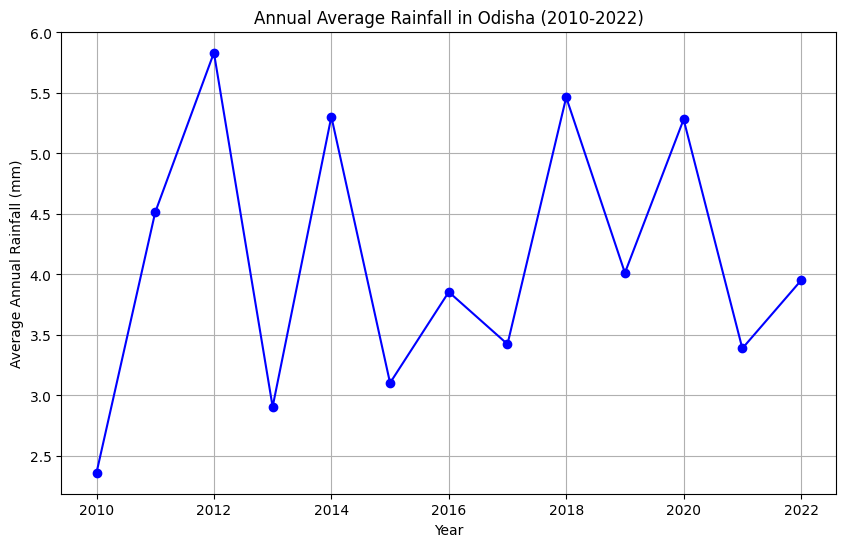

Years above 95th percentile: [2012]
Years below 5th percentile: [2010]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr



# Initialize an empty list to store annual average rainfall
annual_averages = []

# Loop through each year in the specified range (2010 to 2022)
for year in range(2010, 2023):
    # Load the rainfall data for the current year
    rainfall_data = xr.open_dataset(data_path + f'{year}.nc')

    # Find latitude and longitude indices within Odisha's boundaries
    latitude_indices = np.where((rainfall_data['LATITUDE'] >= min_latitude) & (rainfall_data['LATITUDE'] <= max_latitude))[0]
    longitude_indices = np.where((rainfall_data['LONGITUDE'] >= min_longitude) & (rainfall_data['LONGITUDE'] <= max_longitude))[0]

    # Slice the rainfall data for Odisha
    Odisha_rainfall_data = rainfall_data['RAINFALL'][:, latitude_indices, longitude_indices]

    # Calculate the annual average rainfall
    annual_average_rainfall = Odisha_rainfall_data.mean(dim='TIME').sum().item()
    annual_averages.append(annual_average_rainfall)

    # Close the NetCDF dataset to free up resources
    rainfall_data.close()

# Plot the annual average rainfall
plt.figure(figsize=(10, 6))
plt.plot(range(2010, 2023), annual_averages, marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel('Average Annual Rainfall (mm)')
plt.title('Annual Average Rainfall in Odisha (2010-2022)')
plt.grid(True)
plt.show()

# Calculate percentiles
percentile_5 = np.percentile(annual_averages, 5)
percentile_95 = np.percentile(annual_averages, 95)

# Print years above 95th percentile
above_95 = [year for year, avg in zip(range(2010, 2023), annual_averages) if avg > percentile_95]
print(f'Years above 95th percentile: {above_95}')

# Print years below 5th percentile
below_5 = [year for year, avg in zip(range(2010, 2023), annual_averages) if avg < percentile_5]
print(f'Years below 5th percentile: {below_5}')

MONTHLY RAINFALL ANALYSIS FROM 1901 TO 2022

In [ ]:
for month in months:
  # Calculate the Z-scores for the 'month' column
  z_scores = zscore(result_df_pivoted[month])

  # Define a threshold for identifying outliers (e.g., Z-score greater than 2)
  outlier_threshold = 2

  # Identify outlier indices
  outlier_indices = np.where(np.abs(z_scores) > outlier_threshold)[0]

  # Plot the line graph with outliers highlighted
  plt.figure(figsize=(40, 6))
  plt.plot(result_df_pivoted['Year'], result_df_pivoted[month], marker='o', linestyle='-', color='b')
  plt.scatter(result_df_pivoted['Year'].iloc[outlier_indices], result_df_pivoted[month].iloc[outlier_indices], color='r', label='Outliers',  zorder=5)
  plt.xlabel('Years')
  plt.ylabel('Monthly Rainfall (mm)')
  plt.title(f'Monthly Rainfall in Odisha on {month} with Outliers')
  plt.xticks(np.arange(min(result_df_pivoted['Year']), max(result_df_pivoted['Year']) + 1, 1), rotation=45, ha='right')
  plt.legend()
  plt.grid(True)
  plt.show()

  # Print information about outliers
  print(f"Number of Outliers: {len(outlier_indices)}")
  print(f"Outlier Years: {result_df_pivoted['Year'].iloc[outlier_indices].tolist()}")
  print(f"Outlier Values: {result_df_pivoted[month].iloc[outlier_indices].tolist()}")

Output hidden; open in https://colab.research.google.com to view.

TOTAL ANNUAL RAINFALL ANALYSIS FROM 1901 TO 2022

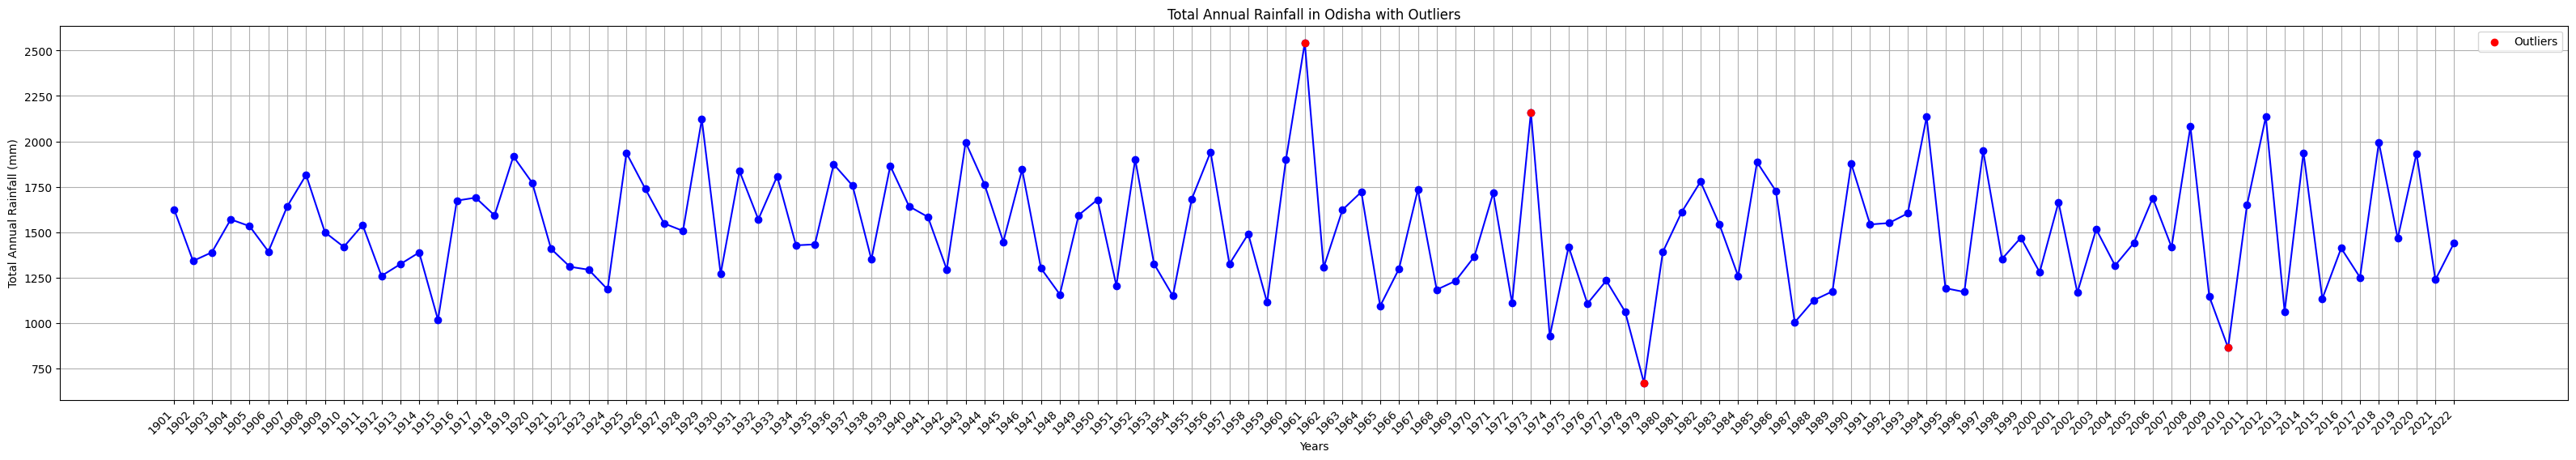

Number of Outliers: 4
Outlier Years: [1961, 1973, 1979, 2010]
Outlier Values: [2543.5816055834293, 2160.620602309704, 669.0029396414757, 861.9955055043101]


In [ ]:
# Calculate the Z-scores for the 'Total Annual Rainfall' column
z_scores = zscore(result_df_pivoted['Total Annual Rainfall'])

# Define a threshold for identifying outliers (e.g., Z-score greater than 2)
outlier_threshold = 2

# Identify outlier indices
outlier_indices = np.where(np.abs(z_scores) > outlier_threshold)[0]

# Plot the line graph with outliers highlighted
plt.figure(figsize=(40, 6))
plt.plot(result_df_pivoted['Year'], result_df_pivoted['Total Annual Rainfall'], marker='o', linestyle='-', color='b')
plt.scatter(result_df_pivoted['Year'].iloc[outlier_indices], result_df_pivoted['Total Annual Rainfall'].iloc[outlier_indices], color='r', label='Outliers',  zorder=5)
plt.xlabel('Years')
plt.ylabel('Total Annual Rainfall (mm)')
plt.title('Total Annual Rainfall in Odisha with Outliers')
plt.xticks(np.arange(min(result_df_pivoted['Year']), max(result_df_pivoted['Year']) + 1, 1), rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.show()

# Print information about outliers
print(f"Number of Outliers: {len(outlier_indices)}")
print(f"Outlier Years: {result_df_pivoted['Year'].iloc[outlier_indices].tolist()}")
print(f"Outlier Values: {result_df_pivoted['Total Annual Rainfall'].iloc[outlier_indices].tolist()}")

10 year Interval Rainfall average

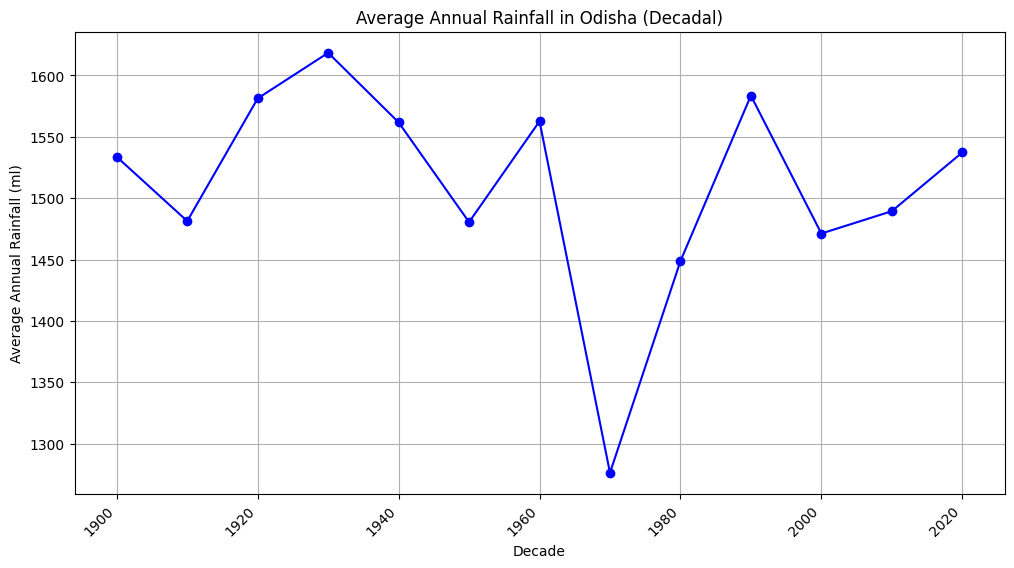

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr


# Calculate average annual rainfall across each 10 years
result_df_pivoted['Decade'] = (result_df_pivoted['Year'] // 10) * 10
decadal_average_rainfall = result_df_pivoted.groupby('Decade')['Total Annual Rainfall'].mean()

# Plot the decadal average annual rainfall as a line plot
plt.figure(figsize=(12, 6))
plt.plot(decadal_average_rainfall.index, decadal_average_rainfall, marker='o', color='b', linestyle='-')
plt.xlabel('Decade')
plt.ylabel('Average Annual Rainfall (ml)')
plt.title(f'Average Annual Rainfall in Odisha (Decadal)')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()

MONTHLY RAINFALL ANALYSIS FROM 1901 TO 2022

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr


# Calculate average annual rainfall across each 10 years
result_df_pivoted['Decade'] = (result_df_pivoted['Year'] // 10) * 10
decadal_average_rainfall = result_df_pivoted.groupby('Decade')['Total Annual Rainfall'].mean()

# Print the mean and standard deviation
mean_rainfall = decadal_average_rainfall.mean()
std_rainfall = decadal_average_rainfall.std()

print(f"Mean Annual Rainfall: {mean_rainfall} mm")
print(f"Standard Deviation of Annual Rainfall: {std_rainfall} mm")

Mean Annual Rainfall: 1509.7338832660619 mm
Standard Deviation of Annual Rainfall: 87.09088497487626 mm


MANN-KENDALL TEST AND SEN SLOPE ESTIMATOR FOR TREND ANALYSIS.
##### Mann-Kendall test : A non-parametric statistical test used to assess the presence of trends in time series data by evaluating the monotonicity of the data over time.

##### Sen Slope Estimator : A method for estimating the slope of a trend in time series data

In [ ]:
# Filter the DataFrame for the desired years (2022 to 2012)
print("Enter the range of years(year1 to year2)")
year1 = int(input())
year2 = int(input())
selected_years = range(year1, year2 + 1)
df_selected_years = result_df_pivoted[result_df_pivoted['Year'].isin(selected_years)]

result, _ = kendalltau(df_selected_years['Year'],df_selected_years['Total Annual Rainfall'])

# Calculate p-value for the Mann-Kendall test
p_value = 2 * norm.cdf(-abs(result))

result_s = linregress(df_selected_years['Year'], df_selected_years['Total Annual Rainfall'])

# Display Mann-Kendall test result
print(f"Mann-Kendall Test Result for Yearly Sum of Rainfall ({year1} to {year2}):")
#print(f"Kendall's Tau: {result}")
print(f"P-value: {p_value}")

# Display Theil-Sen estimator result
print(f"Theil-Sen Estimator Result for Yearly Sum of Rainfall ({year1} to {year2}):")
print(f"Slope (Sen's Slope): {result_s.slope}")

if p_value < 0.05:
    if result_s.slope > 0:
        print("Significant positive trend")
    elif result_s.scope < 0:
        print("Significant negative trend")
    else:
        print("No significant trend")
else:
    print("No significant trend")

Enter the range of years(year1 to year2)
2017
2022
Mann-Kendall Test Result for Yearly Sum of Rainfall (2017 to 2022):
P-value: 0.8414805811217939
Theil-Sen Estimator Result for Yearly Sum of Rainfall (2017 to 2022):
Slope (Sen's Slope): -24.10003875153405
No significant trend


In [ ]:
# Filter the DataFrame for the desired years (2022 to 2012)
print("Enter the range of years(year1 to year2)")
year1 = int(input())
year2 = int(input())
selected_years = range(year1, year2 + 1)
df_selected_years = result_df_pivoted[result_df_pivoted['Year'].isin(selected_years)]

result, _ = kendalltau(df_selected_years['Year'],df_selected_years['Jan'])

# Calculate p-value for the Mann-Kendall test
p_value = 2 * norm.cdf(-abs(result))

result_s = linregress(df_selected_years['Year'], df_selected_years['Jan'])

# Display Mann-Kendall test result
print(f"Mann-Kendall Test Result for Monthly Rainfall of January ({year1} to {year2}):")
#print(f"Kendall's Tau: {result}")
print(f"P-value: {p_value}")

# Display Theil-Sen estimator result
print(f"Theil-Sen Estimator Result for Monthly Rainfall of January ({year1} to {year2}):")
print(f"Slope (Sen's Slope): {result_s.slope}")

if p_value < 0.05:
    if result_s.slope > 0:
        print("Significant positive trend")
    elif result_s.scope < 0:
        print("Significant negative trend")
    else:
        print("No significant trend")
else:
    print("No significant trend")

Enter the range of years(year1 to year2)
2017
2020
Mann-Kendall Test Result for Monthly Rainfall of January (2017 to 2020):
P-value: 0.7388826803635272
Theil-Sen Estimator Result for Monthly Rainfall of January (2017 to 2020):
Slope (Sen's Slope): 3.0320663690567016
No significant trend


PETTITT TEST
##### A non-parametric statistical test used to detect a change point or discontinuity in a time series, indicating a significant shift in the distribution of the data.

In [ ]:
# Filter the DataFrame for the desired years (2022 to 2012)
print("Enter the range of years (year1 to year2)")
year1 = int(input())
year2 = int(input())
selected_years = range(year1, year2 + 1)
df_selected_years = result_df_pivoted[result_df_pivoted['Year'].isin(selected_years)]

# Perform Pettitt test for the selected years
result_pettitt = hg.pettitt_test(df_selected_years['Total Annual Rainfall'])

# Display Pettitt test result
print(f"Pettitt Test Result for Yearly Sum of Rainfall ({year1} to {year2}):")
print(f"Change detected: {result_pettitt.h}")
print(f"Change point index: {result_pettitt.cp}")
print(f"P-value: {result_pettitt.p}")
print(f"Test Statistic (U): {result_pettitt.U}")
print(f"Mean Before Change (mu1): {result_pettitt.avg.mu1}")
print(f"Mean After Change (mu2): {result_pettitt.avg.mu2}")

Enter the range of years (year1 to year2)
2017
2020
Pettitt Test Result for Yearly Sum of Rainfall (2017 to 2020):
Change detected: False
Change point index: 1
P-value: 0.3296
Test Statistic (U): 3.0
Mean Before Change (mu1): 1249.8306284621358
Mean After Change (mu2): 1797.3879914109905


In [ ]:
# Filter the DataFrame for the desired years (2022 to 2012)
print("Enter the range of years (year1 to year2)")
year1 = int(input())
year2 = int(input())
selected_years = range(year1, year2 + 1)
df_selected_years = result_df_pivoted[result_df_pivoted['Year'].isin(selected_years)]

# Perform Pettitt test for the selected years
result_pettitt = hg.pettitt_test(df_selected_years['Jan'])

# Display Pettitt test result
print(f"Pettitt Test Result for Monthly Rainfall of January ({year1} to {year2}):")
print(f"Change detected: {result_pettitt.h}")
print(f"Change point index: {result_pettitt.cp}")
print(f"P-value: {result_pettitt.p}")
print(f"Test Statistic (U): {result_pettitt.U}")
print(f"Mean Before Change (mu1): {result_pettitt.avg.mu1}")
print(f"Mean After Change (mu2): {result_pettitt.avg.mu2}")

Enter the range of years (year1 to year2)
2020
2022
Pettitt Test Result for Monthly Rainfall of January (2020 to 2022):
Change detected: True
Change point index: 2
P-value: 0.0
Test Statistic (U): 2.0
Mean Before Change (mu1): 16.856855899095535
Mean After Change (mu2): 29.84938335418701
